In [ ]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import pandas as pd
import matplotlib.pyplot as plt

# Introduction - Schedule jobs on a bottleneck machine

"What should be done next?" is a question one faces in many different situations.
In this notebook we consider two scheduling problems:

1. A single machine determines the throughput of an entiry production, for example because only one machine of this type is available, its the slowest machine in a production line, etc. . Such a machine is called a bottleneck machine. We ask for an optimal job schedule for the bottleneck machine.

2. We have multiple machines and a set of jobs for them and ask for an optimal job schedule for the machines.

Moreover each job has a start date (release), a duration time and a due time.

Our task is to find an optimal sequence of jobs, but we have not said *what an optimal schedule is.*

In practize there may be different answer to this question depending on the application and the circumstances. Hence we will consider the following key performance indicators (KPIs) to compare different schedules and measure their optimality

- makespan, i.e. minimizing the total duration of the schedule
- maximum of past due days among the jobs
- number of jobs past due
- number of jobs in time
- sum of past due days
- fraction of jobs on time

This notebook is based on [@gueret1999applications, chap. 74] and [@PostekZocca2022].

## Optimal vs. empirical schedules

In order to see the benefit of mathematical optimization we proceed as follows:

1. We visualize and compute KPIs for certain empirical schedules.
1. We visualize and compute KPIs for optimal schedules with respect to different KPIs.
1. We determine an optimal solution for a given set of jobs and a given sets of machines.


## Example

In our discussion we use the following example of jobs.

In [ ]:
jobs = {
    'A': {'release':2, 'duration': 5, 'due': 10},
    'B': {'release':5, 'duration': 6, 'due': 21},
    'C': {'release':4, 'duration': 8, 'due': 15},
    'D': {'release':0, 'duration': 4, 'due': 10},
    'E': {'release':0, 'duration': 2, 'due':  5},
    'F': {'release':8, 'duration': 3, 'due': 15},
    'G': {'release':9, 'duration': 2, 'due': 22}
}
pd.DataFrame(jobs).T.rename(columns = {'release': 'release time', 
                                       'duration': 'duration in hours',
                                      'due':'due time'})

,release time,duration in hours,due time
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


## GANTT charts

Schedules can be visualised using GANTT charts. In the next cells we define some helper functions, for example to plot a Gantt chart.

Afterwards we consider empirical schedules, in particular we consider:

- First-In First-Out (FIFO)
- Last-In, First-Out (LIFO)
- Shortest Processing Time First (SPT)
- Earliest Due Data (EDD)

In [ ]:
# copy and pasted from jeffrey !
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()
    
    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

In [ ]:
# jeffrery's code !
def schedule(JOBS, order):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}
    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE

In [ ]:
# mainly jeffrery's code !
def schedule_from_model(m, machines = 1):
    SCHEDULE = {}
    for j in m.jobs:
        if machines == 1:
            tmp = 1
        else:
            tmp = [mach for mach in machines if pyo.value(m.job_to_machine[j,mach]) == 1][0]
        SCHEDULE[j] = {
            'start': m.start[j](), 
            'finish': m.start[j]() + m.duration[j],
            'machine': tmp
        }
    return SCHEDULE

In [ ]:
# jeffreys code
## KPI for job schedule
def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

# Empirical schedules

## A Manual Schedule

By specifying schedules we can evaluate and compare them. The following snippet shows how the user can specify a schedule and judge its performance through the KPIs.

We invite the reader to spend some minutes trying to find a better schedule.
Spoiler: The given schedule here is already optimal in a way we will see later.

{'Makespan': 30,
 'Max Pastdue': 15,
 'Sum of Pastdue': 16,
 'Number Pastdue': 2,
 'Number on Time': 5,
 'Fraction on Time': 0.7142857142857143}

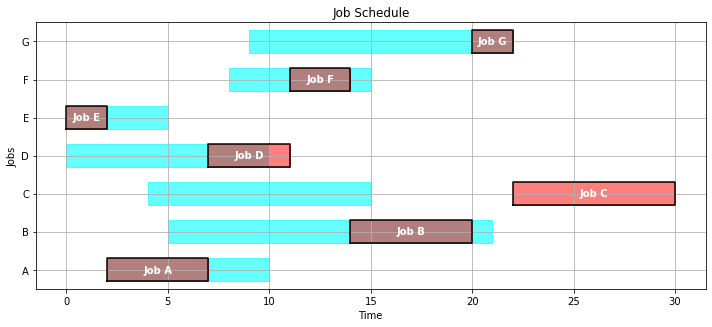

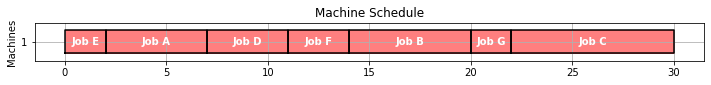

In [ ]:
# define schedule
job_order = ['E','A','D','F','B','G','C']

# visualize schedule
SCHEDULE = schedule(jobs, order=job_order)
gantt(jobs, SCHEDULE)
kpi(jobs, SCHEDULE)

## Alphabetic schedule

Lets assume the schedule is given by the names of the Jobs. This chould represent a case in which the schedule is predefined through its names by a human or by previous processes.

{'Makespan': 32,
 'Max Pastdue': 22,
 'Sum of Pastdue': 68,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

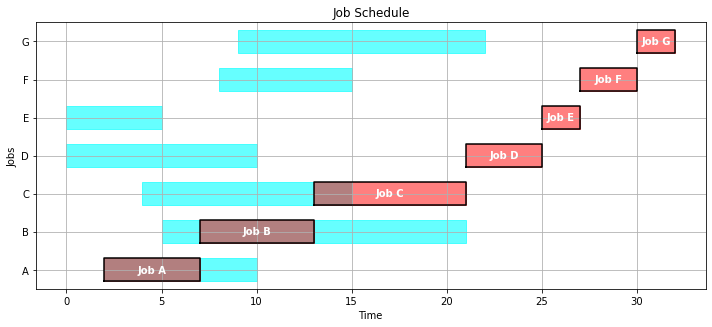

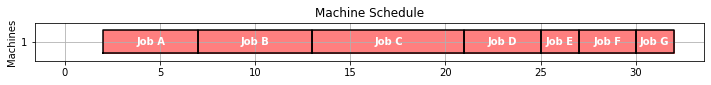

In [ ]:
SCHEDULE = schedule(jobs, order=sorted(jobs.keys()))
gantt(jobs, SCHEDULE)
kpi(jobs, SCHEDULE)

## FIFO - first in first out

We evaluate a schedule, in which the ordering is defined by the release time of the job, i.e. what comes first is done first.

{'Makespan': 30,
 'Max Pastdue': 13,
 'Sum of Pastdue': 31,
 'Number Pastdue': 6,
 'Number on Time': 1,
 'Fraction on Time': 0.14285714285714285}

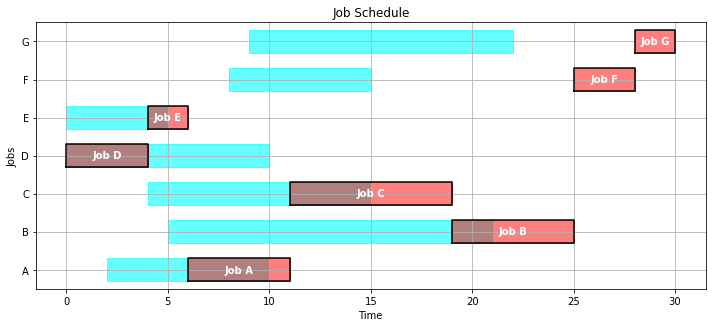

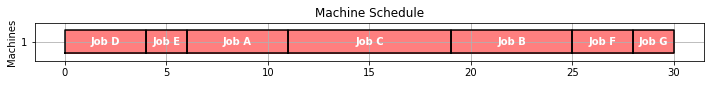

In [ ]:
def fifo(JOBS):
    order_by_release = sorted(JOBS, key=lambda job: JOBS[job]['release'])
    return schedule(JOBS, order_by_release)

gantt(jobs, fifo(jobs))
kpi(jobs, fifo(jobs))

## LIFO - last in first out

We put the jobs on a stack as follows: At time $t$ we put all jobs with release time equal to $t$ on top of the stack. If the machine has a free capacity, we assign the job which is on top of the stack to the machine and remove the job from the stack.

{'Makespan': 30,
 'Max Pastdue': 20,
 'Sum of Pastdue': 34,
 'Number Pastdue': 3,
 'Number on Time': 4,
 'Fraction on Time': 0.5714285714285714}

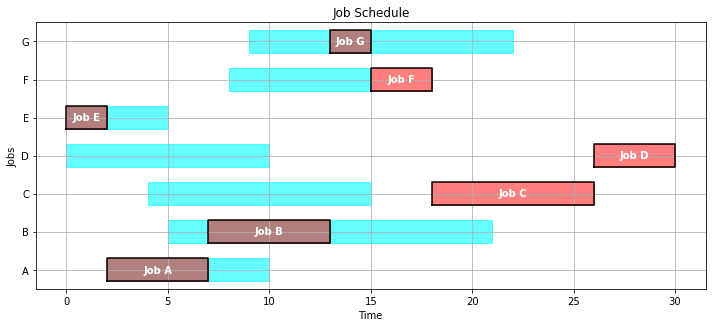

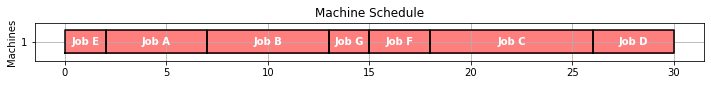

In [ ]:
def lifo(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        lifo = {job:JOBS[job]['release'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = max(lifo, key=lifo.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(jobs, lifo(jobs))
kpi(jobs, lifo(jobs))

## SPT - shortest processing time

Shortest processing time (SPT) is a scheduling policy that selects for execution the waiting job with the smallest execution time.


{'Makespan': 30,
 'Max Pastdue': 15,
 'Sum of Pastdue': 18,
 'Number Pastdue': 4,
 'Number on Time': 3,
 'Fraction on Time': 0.42857142857142855}

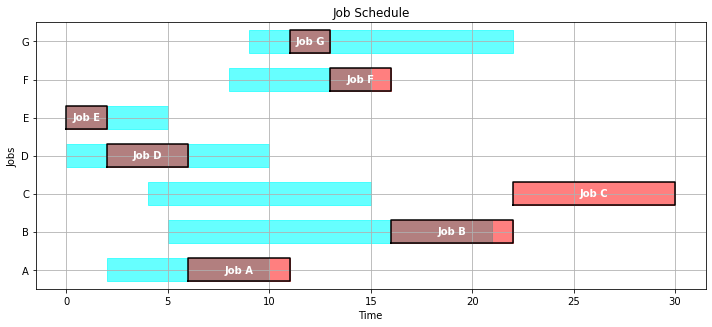

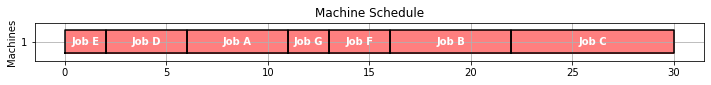

In [ ]:
def spt(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        spt = {job:JOBS[job]['duration'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = min(spt, key=spt.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(jobs, spt(jobs))
kpi(jobs, spt(jobs))

## EDD - earliest due date

Earliest due date (EDD) is a dynamic priority scheduling algorithm used in real-time operating systems to place processes in a priority queue. Whenever a scheduling event occurs (task finishes, new task released, etc.) the queue will be searched for the process closest to its deadline.

{'Makespan': 30,
 'Max Pastdue': 8,
 'Sum of Pastdue': 27,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

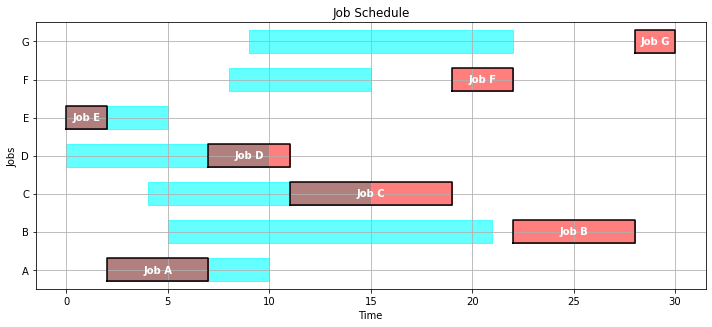

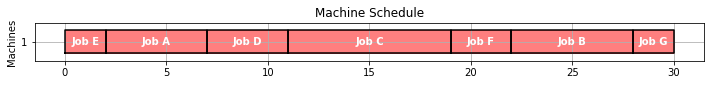

In [ ]:
def edd(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        edd = {job:JOBS[job]['due'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = min(edd, key=edd.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(jobs, edd(jobs))
kpi(jobs, edd(jobs))

# Optimal schedules - one machine

## Modeling

We give a algebraic representation of the model. 

### Sets

- $J$ set of unique job IDs $j$
- $order:= \{(i,j)~|~i,j\in J\}$ - used to define weather job $j$ is executed before job $i$ or not 

### Parameter

- $due_j$ due time of job $j$
- $duration_j$ duration of job $j$
- $release_j$ time job $j$ becomes available for processing


### Decision variables 

- $start_j$ start of job $j$

### State variables 

- $finished_j$ time by which job $j$ finishes
- $pastdue_j$ time by which job $j$ is past due
- $early_j$ time by which job $j$ is finished early


### Constraints

1. job can not start until it is released for processing

$$
start_j\geq release_j
$$

2. expressing timeline and how time variables are related

$$
\begin{array}{rl}
start_j + duration_j + early_j &= due_j + pastdue_j \\
early_j & \geq 0 \\
pastdue_j & \geq 0
\end{array}
$$

3. definition of the objective `makespan` 

$$
finish_j \leq makespan
$$

4. definition of state variable `finish_j`

$$
start_j + duration_j = finish_j
$$

5. No pair of jobs operates on the same machine at the same time.

This can be easily express as a set of disjunctions as follows:

$$
\left[finish_i \leq start_j \right] \vee \left[finish_j \leq start_i \right], \; \forall i<j
$$


### Objective

As we have mentioned in the introduction the application and circumstances define what an optimal schedule is.

## Implementation

The following implementation allows optimizing with respect to the following objectives:
- `makespan`, i.e. the time to complete all jobs
- `sum_pastdue`, i.e. sum of past due 

In [ ]:
def model_1_machine(jobs, optimize = "makespan"):
    
    m = pyo.ConcreteModel()
    
    # sets
    m.jobs = pyo.Set(initialize = jobs.keys())
    m.order = pyo.Set(initialize = m.jobs * m.jobs, dimen = 2, filter = lambda m,i,j : i < j)
    
    # parameters
    @m.Param(m.jobs, doc = "job due time")
    def due(m,i):
        return jobs[i]['due']
    @m.Param(m.jobs, doc = "job duration time")
    def duration(m,i):
        return jobs[i]['duration']
    @m.Param(m.jobs, doc = "job release time")
    def release(m,i):
        return jobs[i]['release']
    
    # upper bound on decision variables, in this case we choose the worst case 
    max_time = sum(m.duration[i] for i in m.jobs) + max(m.release[i] for i in m.jobs)
    
    # decision variables
    m.start = pyo.Var(m.jobs, domain = pyo.NonNegativeReals, bounds = (0, max_time))
    ## additional variables
    m.finish = pyo.Var(m.jobs, domain = pyo.NonNegativeReals, bounds = (0, max_time))
    m.pastdue = pyo.Var(m.jobs, domain = pyo.NonNegativeReals, bounds = (0, max_time))
    m.early = pyo.Var(m.jobs, domain = pyo.NonNegativeReals, bounds = (0,max_time))
    
    # addtional variables for objectives
    m.makespan = pyo.Var(domain = pyo.NonNegativeReals, bounds = (0, max_time), doc = "time until all jobs are done")
    m.maxpastdue = pyo.Var(domain = pyo.NonNegativeReals, bounds = (0,max_time), doc = "time")
    m.ispastdue = pyo.Var(m.jobs, domain = pyo.Binary)
    
    # objective
    if optimize == 'makespan':
        m.OBJ = pyo.Objective(expr = m.makespan, sense = pyo.minimize)
    elif optimize == 'sum_pastdue':
        m.OBJ = pyo.Objective(expr = sum([m.pastdue[i] for i in m.jobs]), sense = pyo.minimize)
    else:
        print('wrong value for parameter optimize. allowed are "makespan" or "sum_pastdue" optimize = makespan used instead.')
        m.OBJ = pyo.Objective(expr = m.makespan, sense = pyo.minimize)

    # constraints
    @m.Constraint(m.jobs)
    def job_finish(m,i, doc = "defines job time finish"):
        return m.finish[i] == m.start[i] + m.duration[i]
    @m.Constraint(m.jobs, doc = "release before start")
    def start_after_release(m,i):
        return m.start[i] >= m.release[i]
    @m.Constraint(m.jobs, doc ="describe position of job w.r.t. time in schedule")
    def time_relations(m,i):
        return m.start[i] + m.duration[i] + m.early[i] == m.due[i] + m.pastdue[i]
    @m.Constraint(m.jobs, doc = "finish time lower than make span")
    def finish_lower_makespan(m,i):
        return m.finish[i] <= m.makespan
    
    m.schedule = gdp.Disjunction(m.order, rule = lambda m,i,j:
                                [m.finish[i] <= m.start[j],
                                 m.finish[j] <= m.start[i]])
    
    @m.Constraint(m.jobs, doc = "past due lower than max past due")
    def pastdue_lower_maxpastdue(m,i):
        return m.pastdue[i] <= m.maxpastdue
    @m.Constraint(m.jobs, doc ="")
    def pastdue_lower_max_time(m,i):
        return m.pastdue[i] <= max_time * m.ispastdue[i]
    pyo.TransformationFactory('gdp.hull').apply_to(m)
    pyo.SolverFactory('glpk').solve(m)#.write()
    
    return m

### Optimal `makespan`

By defintion `makespan` is the time to complete all jobs.

{'Makespan': 30.0,
 'Max Pastdue': 11.0,
 'Sum of Pastdue': 29.0,
 'Number Pastdue': 3,
 'Number on Time': 4,
 'Fraction on Time': 0.5714285714285714}

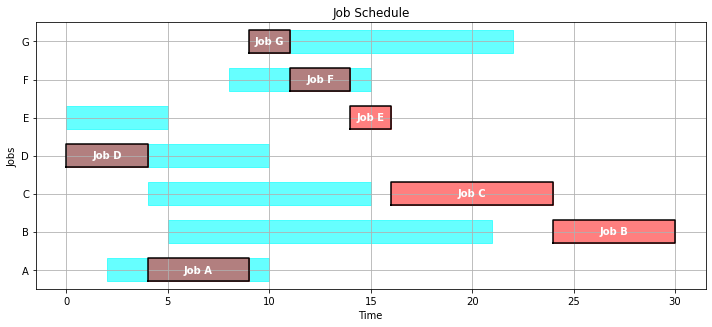

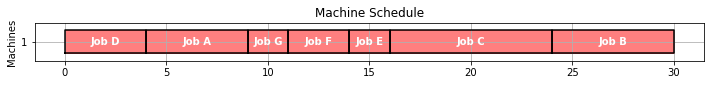

In [ ]:
model = model_1_machine(jobs, optimize = "makespan")
SCHEDULE = schedule_from_model(model)
gantt(jobs, SCHEDULE)
kpi(jobs, SCHEDULE)

# Optimal `sum past due`

By definition `sum_pastdue` is sum of the times the jobs are past due.

{'Makespan': 30.0,
 'Max Pastdue': 15.0,
 'Sum of Pastdue': 16.0,
 'Number Pastdue': 2,
 'Number on Time': 5,
 'Fraction on Time': 0.7142857142857143}

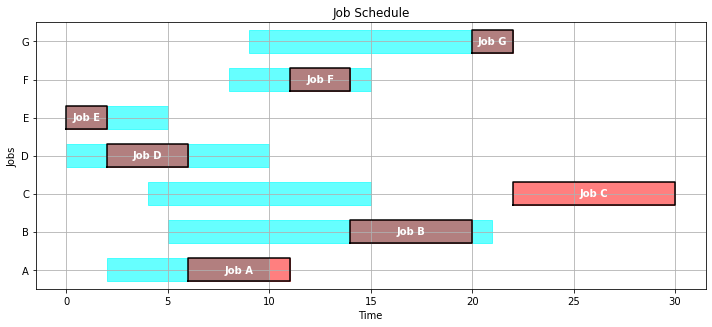

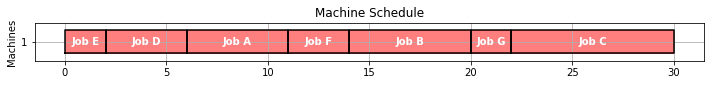

In [ ]:
model = model_1_machine(jobs, optimize = "sum_pastdue")
SCHEDULE = schedule_from_model(model)
gantt(jobs, SCHEDULE)
kpi(jobs, SCHEDULE)

# Optimal schedules - multiple machines 

Because the previous model can be extended to multiple machines easily we include this case in this notebook.

## Modeling

The algebraic representation of the model is the following:

## Sets

- $machines$ - elements are abbreviated with $m$
- $jobs$ - elements are abbreviated with $j$ or $i$
- $order:= jobs \times jobs$ - schedule order of jobs

## Parameters
- $release_j$
- $duration_j$
- $due_j$
- $BigM$ - big M integer in modeling the disjunctions

## Variables

### Decision variables

- $start_i$ - time job $i$ starts
- $job\_to\_machine_{j,m}$ - binary variable, 1 iff job $j$ is assigned to machine $m$

### State variables

- $pastdue_i$ - time job $i$ is past due
- $early_i$ - time job $i$ is finished early


### Assignment to machines
- $\text{job_to_machine}_{j,m}$ - binary assingment of jobs to machine; $\text{job_to_machine}_{j,m}==1$ iff job $j$ is executed on $m$
                                                                        
### Objective vars
- makespan - non negative real
- ispastdue - binary, 1 iff job finish past due
- maxpastdue - non negative real

### Constraints

Because the following model should work for different objective functions some constraints might be unused for a given objective function, but we believe it is easy to identify them.

$$
\begin{array}{llc}
  start_j \geq release_j & \;\forall j\in jobs & c_1\\
  start_j + duration_j + early_j = due_j + pastdue_j & \;\forall j\in jobs &c_2\\
  [early_j==0] \vee [pastdue_j == 0] & \;\forall j\in jobs & d_1\\
  [pastdue_j == 0] \vee [ispastdue_j == 1] & \;\forall j\in jobs & d_2\\
  \sum_m jobs\_to\_machine_{j,m} = 1 & \;\forall j\in jobs, \forall m \in machines & c_3\\
  pastdue_j <= maxpastdue & \;\forall j\in jobs & c_4\\
  start_j + duration_j <= makespan & \;\forall j\in jobs & c_5\\
  [T1] \vee_{i,j,m} [T2] & \;\forall i,j \in order, \forall m \in machines & d_3
\end{array}
$$

where
$$
\begin{array}{c}
T1 := start_i + duration_i \leq start_j + M(1-jobs\_to\_machine_{i,m}) +  M(1-jobs\_to\_machine_{j,m})\\
T2 := start_j + duration_j \leq start_i + M(1-jobs\_to\_machine_{i,m}) +  M(1-jobs\_to\_machine_{j,m})
\end{array}
$$

### Constraints explaination

- $c_1$ job starts after its release
- $c_2$ relation among time variables - required because not all jobs may finish before their due time
- $d_1$ job is either early or pastdue
- $d_2$ definition of objective variable ispastdue
- $c_3$ each job is assign to one and only one machine
- $c_4$ definition of objective variable maxpastdue
- $c_5$ definition of objective variable makespan
- $d_3$ job $j$ does not start before previous job $i$ has finished on machine $m$

## Example scheduling multiple machines

We consider two machines which should perform the following jobs:

In [ ]:
machines = ['1','2']
jobs = {
    'A': {'release':2, 'duration': 5, 'due': 10},
    'B': {'release':5, 'duration': 6, 'due': 21},
    'C': {'release':4, 'duration': 8, 'due': 15},
    'D': {'release':0, 'duration': 4, 'due': 10},
    'E': {'release':0, 'duration': 2, 'due':  5},
    'F': {'release':8, 'duration': 3, 'due': 15},
    'G': {'release':9, 'duration': 2, 'due': 22}
}

In [ ]:
def model_multiple_machines(jobs, machines, optimize = 'makespan'):
    #instanciate model
    m = pyo.ConcreteModel("multiple jobs, multiple workers")
    
    # index sets
    m.jobs = pyo.Set(initialize = jobs.keys())
    m.machines = pyo.Set(initialize = machines)
    m.order = pyo.Set(initialize = m.jobs * m.jobs, dimen = 2, filter = lambda m,i,j: i<j)
    
    # parameters
    @m.Param(m.jobs, doc = "job due time")
    def due(m,i):
        return jobs[i]['due']
    @m.Param(m.jobs, doc = "job duration time")
    def duration(m,i):
        return jobs[i]['duration']
    @m.Param(m.jobs, doc = "job release time")
    def release(m,i):
        return jobs[i]['release']
    # doc = "big M integer in modeling disjunctions" and apply hull transform
    BigM = max([m.release[j] for j in m.jobs]) + sum([m.duration[j] for j in m.jobs])
    
    # variables
    ## decision / timeline variables
    m.start = pyo.Var(m.jobs, domain = pyo.NonNegativeReals,
                      bounds = (0, 1000) ,
                      doc = "start time of job")
    m.pastdue = pyo.Var(m.jobs, domain = pyo.NonNegativeReals,
                        bounds = (0, 1000),
                        doc = "time job is past due")
    m.early = pyo.Var(m.jobs, domain = pyo.NonNegativeReals,
                      bounds = (0, 10000),
                      doc = "time job is finished early")
    
    ## objective variables
    m.makespan = pyo.Var(domain = pyo.NonNegativeReals, doc = "time to complete all jobs")
    m.ispastdue = pyo.Var(m.jobs, domain = pyo.Binary, doc = "binary iff job is overdue")
    m.maxpastdue = pyo.Var(domain = pyo.NonNegativeReals, doc = "")
    
    ## additional variales
    m.job_to_machine = pyo.Var(m.jobs, m.machines, domain = pyo.Binary, doc = "binary assignment job to machine")
    
    # objective
    if optimize == 'makespan':
        m.OBJ = pyo.Objective(expr = m.makespan, sense = pyo.minimize)
    elif optimize == 'sum_pastdue':
        m.OBJ = pyo.Objective(expr = sum([m.pastdue[i] for i in m.jobs]), sense = pyo.minimize)
    else:
        print('wrong value for parameter optimize. allowed are "makespan" or "sum_pastdue" optimize = makespan used instead.')
        m.OBJ = pyo.Objective(expr = m.makespan, sense = pyo.minimize)

    # constraint / disjunctions
    @m.Constraint(m.jobs, doc = "job start after release")
    def c1(m,i):
        return m.start[i] >= m.release[i]
    
    @m.Constraint(m.jobs, doc = "time variable relation")
    def c2(m,i):
        return m.start[i] + m.duration[i] + m.early[i] == m.due[i] + m.pastdue[i]
    
    @m.Disjunction(m.jobs, doc = "job either early or pastdue")
    def d1(m,i):
        return [m.early[i]==0, m.pastdue[i]==0]
    
    @m.Disjunction(m.jobs, doc = "")
    def d2(m,j):
        return [m.pastdue[j] == 0, m.ispastdue[j] == 1],
    
    @m.Constraint(m.jobs, doc = "each job is assigned to one and only one machine")
    def c3(m,j):
        return (sum(m.job_to_machine[j,machine] for machine in m.machines) == 1)
    
    @m.Constraint(m.jobs, doc = "define objective variable maxpastdue")
    def  c4(m,j):
        return m.pastdue[j] <= m.maxpastdue
    
    @m.Constraint(m.jobs, doc = "define objective variable makespan")
    def c6(m,i):
        return m.start[i] + m.duration[i] <= m.makespan
    
    @m.Disjunction(m.machines, m.order, doc = "ordering of jobs")
    def d3(m, machine, i,j):
        return [m.start[i] + m.duration[i] <= m.start[j] + BigM * ((1 - m.job_to_machine[i,machine]) + (1 - m.job_to_machine[j,machine])),
                m.start[j] + m.duration[j] <= m.start[i] + BigM * ((1 - m.job_to_machine[i,machine]) + (1 - m.job_to_machine[j,machine]))
               ]
    transform = pyo.TransformationFactory('gdp.hull')
    transform.apply_to(m)
    # solve model
    pyo.SolverFactory('glpk').solve(m)
    return m

## Optimal `makespan` - multiple machines

{'Makespan': 15.0,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 7,
 'Fraction on Time': 1.0}

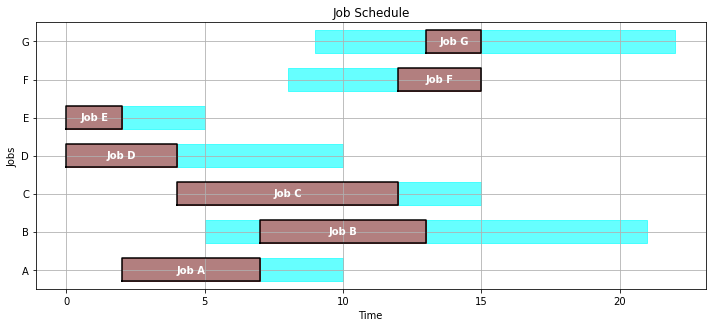

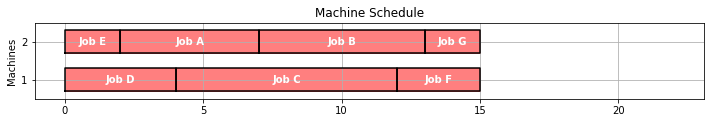

In [ ]:
model = model_multiple_machines(jobs, machines, optimize = 'makespan')
SCHEDULE = schedule_from_model(model, machines)
gantt(jobs, SCHEDULE)
kpi(jobs, SCHEDULE)

# Optimal `sum past due` - multiple machines

By definition `sum_pastdue` is sum of the times the jobs are past due.

{'Makespan': 21.0,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 7,
 'Fraction on Time': 1.0}

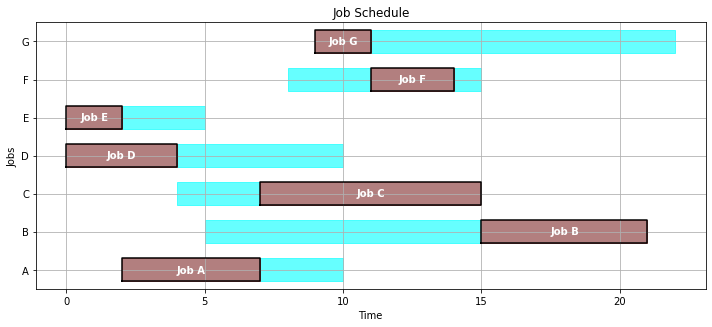

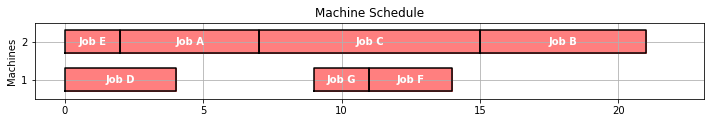

In [ ]:
model = model_multiple_machines(jobs, machines, optimize = 'sum_pastdue')
SCHEDULE = schedule_from_model(model, machines)
gantt(jobs, SCHEDULE)
kpi(jobs, SCHEDULE)

# Discussion one machines

We see that for the choosen empirical schedules maximal 3 jobs are done on time, whereas for the optimal solutions either 4 jobs (optimize `makespan`) or 5 jobs (optimize `sum_pastdue`) are done on time.

# Discussion multiple machines

Having a second machine let us find schedules in which all jobs are done on time.

But we see that the optimal solutions are different
- with respect to the sum of `pastdue` leads to a solution in which one machine has breaks 
- whereas for `makespan` both machines are constantly working on jobs.